In [1]:
from numpy.typing import ArrayLike
import numpy as np
import matplotlib.pyplot as plt

def BrokenPowerLaw(x: ArrayLike, amplitude: float, breaks: ArrayLike, alphas: ArrayLike) -> np.ndarray:
    alphas_array = np.array(alphas)
    cumprod = np.cumprod(breaks ** (alphas_array[:-1] - alphas_array[1:]))

    fx = amplitude * np.array(x) ** alphas[0]
    for i in range(len(breaks)):
        if i < len(breaks) - 1:
            fx = np.where((x > breaks[i]) & (x <= breaks[i+1]), amplitude * x ** alphas[i+1] * cumprod[i], fx)
        else:
            fx = np.where(x > breaks[i], amplitude * x ** alphas[i+1] * cumprod[i], fx)
           
    return fx

def SmoothlyBrokenPowerLaw(x: ArrayLike, amplitude: float, breaks: ArrayLike, alphas: ArrayLike, delta: float) -> np.ndarray:
    breakpoint_array = np.expand_dims(breaks, 0)
    alphas_array = np.array(alphas)
    alphas_diff_array = np.expand_dims(alphas_array[1:] - alphas_array[:-1], 0)
    x_array = np.expand_dims(x, 1)
    prod_array = (1 + (x_array/breakpoint_array) ** (1/delta)) ** (alphas_diff_array * delta)
    fx = amplitude * x ** alphas[0] * np.prod(prod_array, axis=1)
    return fx

In [12]:
h = np.linspace(1, 20, 201)
a = 0.01
breaks = [8]
alphas = [2, 4]
q = SmoothlyBrokenPowerLaw(h, a, breaks, alphas, 0.1)

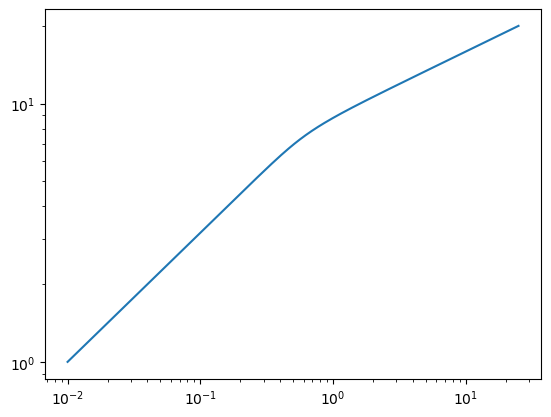

In [13]:
plt.loglog(q, h)

In [14]:
from ratingcurve.experimental import SmoothPowerLawRating
# from ratingcurve import data
import arviz as az

# # load tutorial data
# df = data.load('green channel')

# initialize the model
smoothpowerrating = SmoothPowerLawRating(q=q,
                                         h=h, 
                                         #q_sigma=0.001*q,
                                         segments=2)
                                         #prior={'distribution':'normal','mu':[5], 'sigma':[0.2]})
trace = smoothpowerrating.fit()
data = smoothpowerrating.table(trace, h)

Convergence achieved at 51400
Interrupted at 51,399 [25%]: Average Loss = 3,421.7


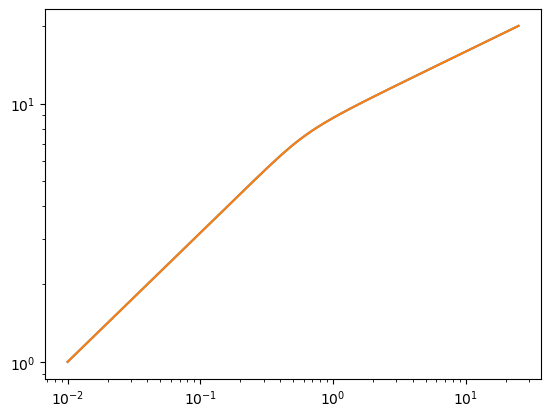

In [15]:
plt.loglog(q, h)
plt.loglog(data['discharge'], data['stage'])

In [10]:
print(trace.posterior.w.mean(axis=1).values, np.exp(trace.posterior.a.mean().values), trace.posterior.hs.mean().values, trace.posterior.delta.mean().values, trace.posterior.sigma.mean().values)
print(trace.posterior.w.std(axis=1).values, trace.posterior.a.std().values, trace.posterior.hs.std().values, trace.posterior.delta.std().values, trace.posterior.sigma.std().values)

[[[0.9799083 ]
  [0.95334423]]] 0.20985127476691262 12.584347651860192 0.4042214562112109 1.9853139717651676
[[[0.02351226]
  [0.05409709]]] 0.13894235246158235 5.0822071311915575 0.2142031090618632 0.10004481169345578


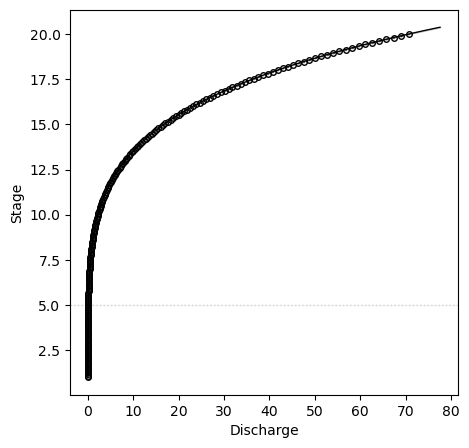

In [7]:
smoothpowerrating.plot(trace)

In [9]:
from ratingcurve.ratingmodel import PowerLawRating

powerrating = PowerLawRating(q=q,
                             h=h, 
                             #q_sigma=0.03*q,
                             segments=2)
trace_pl = powerrating.fit()
data_pl = powerrating.table(trace_pl, h)

Convergence achieved at 122100
Interrupted at 122,099 [61%]: Average Loss = 1,985.4


In [10]:
print(trace_pl.posterior.w.mean(axis=1).values, trace_pl.posterior.a.mean().values, trace_pl.posterior.hs.mean(axis=1).values)

[[0.62131087 0.56698064]] -2.0773929615551068 [[[0.01755825]
  [6.58825269]]]


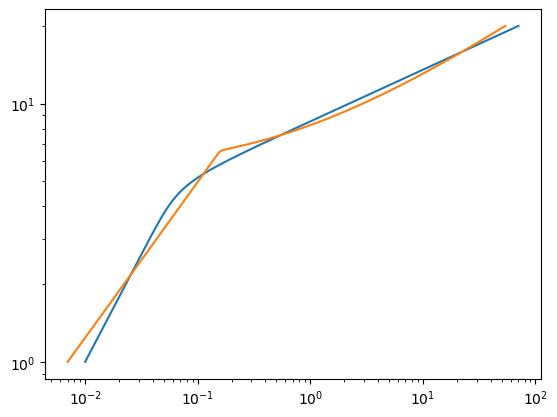

In [11]:
plt.loglog(q, h)
plt.loglog(data_pl['discharge'], data_pl['stage'])

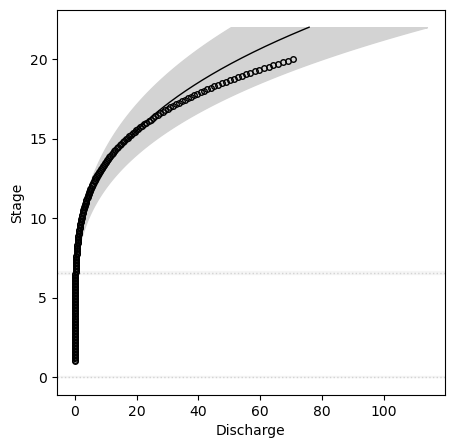

In [11]:
powerrating.plot(trace_pl)